In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!unzip -q "/content/gdrive/MyDrive/EPAM CV/Week 2. Classification/data/Classification_data.zip"

Mounted at /content/gdrive/


In [2]:
import os
import cv2
import glob
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.filters import sobel

In [3]:
# from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [4]:
print(os.listdir("/content/Classification_data/train"))

['buildings', 'street', 'glacier', 'mountain', 'sea', 'forest']


In [5]:
#Resize images to
SIZE = 128

#Capture images and labels into arrays.
#Start by creating empty lists.
train_images = []
train_labels = [] 
for directory_path in glob.glob("/content/Classification_data/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for i, img_path in enumerate(glob.glob(os.path.join(directory_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional step. Change BGR to RGB
        train_images.append(img)
        train_labels.append(label)
        if i+1 == 500:
            break

x_train = np.array(train_images)
y_train = np.array(train_labels)

buildings
street
glacier
mountain
sea
forest


In [6]:
#Do exactly the same for test/validation images
# test
test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/Classification_data/test/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for i, img_path in enumerate(glob.glob(os.path.join(directory_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional
        test_images.append(img)
        test_labels.append(label)
        if i+1 == 500:
            break
        
x_test = np.array(test_images)
y_test = np.array(test_labels)

buildings
street
glacier
mountain
sea
forest


In [7]:
# Encode labels from text (folder names) to integers.

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [8]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [9]:
###################################################################
# FEATURE EXTRACTOR function
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    x_train = dataset
    result = np.zeros((x_train.shape[0] , 245760))

    for i, image in tqdm(enumerate(range(x_train.shape[0] )), total=x_train.shape[0] ):  # #   
        # FEATURE 1 - Pixel values
        features = x_train[image, :,:,:].reshape(-1)        

        # FEATURE 2 - Bunch of Gabor filter responses
        # Generate Gabor features
        num = 1 
        for theta in range(2):  # Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  # Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  # Label Gabor columns as Gabor1, Gabor2, etc.
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel).reshape(-1)
                features = np.hstack([features, filtered_img])
        # features = np.expand_dims(features, axis=0)
        result[i] = features
        # FEATURE 3 Sobel
        #  edge_sobel = sobel(img)
        #  edge_sobel1 = edge_sobel.reshape(-1)
        #  df['Sobel'] = edge_sobel1

    return result

In [10]:
####################################################################
#Extract features from train and test images
image_features = feature_extractor(x_train)
test_features = feature_extractor(x_test)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/2911 [00:00<?, ?it/s]

In [11]:
#Define the classifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Fit the model on training data
RF_model.fit(image_features, y_train) # For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [13]:
#Predict on test
test_prediction = RF_model.predict(test_features)
#Inverse le transform to get original label back. 
# test_prediction = le.inverse_transform(test_prediction)

In [14]:
#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

Accuracy =  0.556166265888011


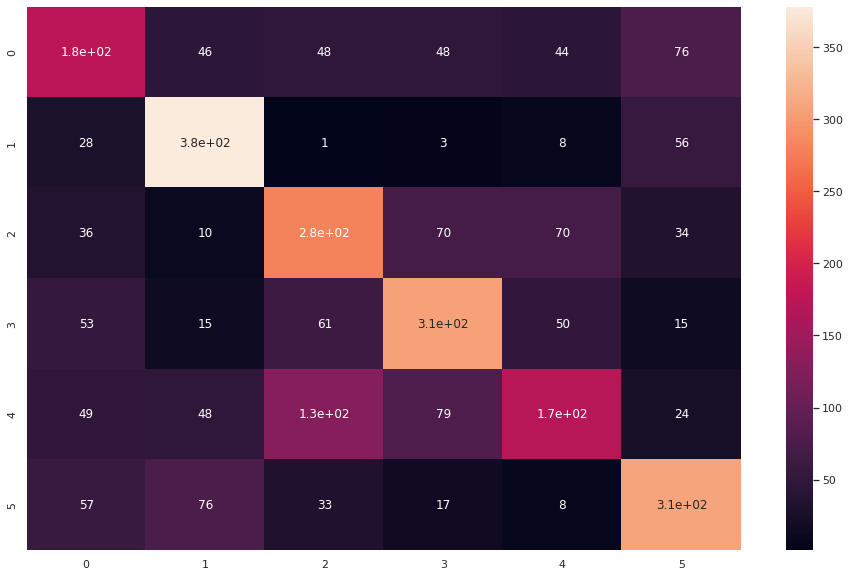

In [20]:
#Print confusion matrix

cm = confusion_matrix(y_test, test_prediction)

fig, ax = plt.subplots(figsize=(16,10))         # Sample figsize in inches
sns.set(font_scale=1)
sns.heatmap(cm.astype(int), annot=True, ax=ax)